## Q1. Running Elastic 

Run Elastic Search 8.17.6, and get the cluster information. If you run it on localhost, this is how you do it:

```bash
curl localhost:9200
```

What's the `version.build_hash` value?

* "build_hash" : "dbcbbbd0bc4924cfeb28929dc05d82d662c527b7"

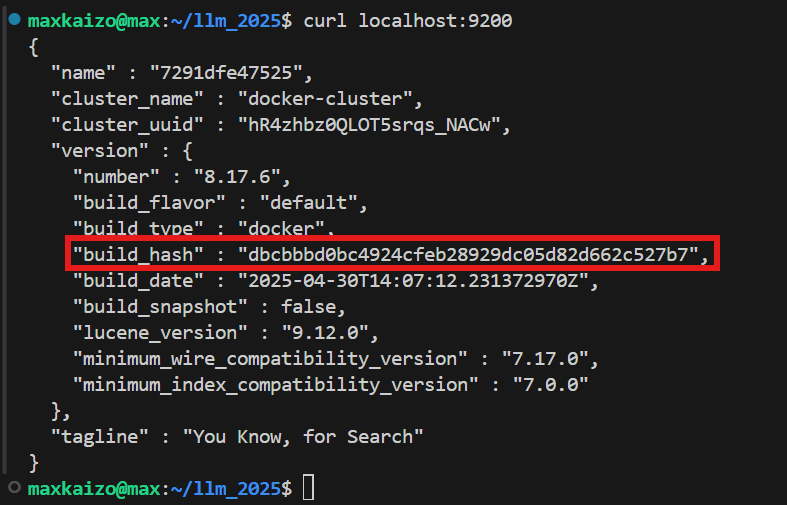

## Getting the data

Now let's get the FAQ data. You can run this snippet:

```python
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)
```

Note that you need to have the `requests` library:

```bash
pip install requests
```


In [1]:
import requests 

docs_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/01-intro/documents.json?raw=1'
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course['course']

    for doc in course['documents']:
        doc['course'] = course_name
        documents.append(doc)

## Q2. Indexing the data

Index the data in the same way as was shown in the course videos. Make the `course` field a keyword and the rest should be text. 

Don't forget to install the ElasticSearch client for Python:

```bash
pip install elasticsearch
```

Which function do you use for adding your data to elastic?

* `insert`
* `index`
* `put`
* `add`


In [3]:
documents[:3]

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp'},
 {'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'section': 'General course-related questions',
  'question': 'Course - What are the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp'},
 {'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines 

In [4]:
from elasticsearch import Elasticsearch

In [5]:
es_client = Elasticsearch('http://localhost:9200') 

In [6]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"} 
        }
    }
}

index_name = "course-questions"

es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [7]:
from tqdm.auto import tqdm

In [8]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

* Answer = index

## Q3. Searching

Now let's search in our index. 

We will execute a query "How do execute a command on a Kubernetes pod?". 

Use only `question` and `text` fields and give `question` a boost of 4, and use `"type": "best_fields"`.

What's the score for the top ranking result?

* 84.50
* 64.50
* 44.50
* 24.50

Look at the `_score` field.

In [22]:
query = 'How do execute a command on a Kubernetes pod?'

In [23]:
search_query = {
    "size": 5,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
        }
    }
}

In [24]:
response = es_client.search(index=index_name, body=search_query)
response

ObjectApiResponse({'took': 47, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 739, 'relation': 'eq'}, 'max_score': 44.50556, 'hits': [{'_index': 'course-questions', '_id': 'TB9XapcBBfox9knDdIOZ', '_score': 44.50556, '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)', 'section': '5. Deploying Machine Learning Models', 'question': 'How do I debug a docker container?', 'course': 'machine-learning-zoomcamp'}}, {'_index': 'course-questions', '_id': '2x9XapcBBfox9knDeYNK', '_score': 35.433445, '_source': {'text': 'Deploy and Access the Kubernetes Dashboard\nLuke', 'section': '10. Kubernetes and TensorFlow Serving', 'question': 'Kubern

In [27]:
result_docs = []

for hit in response['hits']['hits']:
    result_docs.append(hit['_score'])

result_docs

[44.50556, 35.433445, 33.70974, 33.2635, 32.589073]

* Answer = 44.50

## Q4. Filtering

Now ask a different question: "How do copy a file to a Docker container?".

This time we are only interested in questions from `machine-learning-zoomcamp`.

Return 3 results. What's the 3rd question returned by the search engine?

* How do I debug a docker container?
* How do I copy files from a different folder into docker container’s working directory?
* How do Lambda container images work?
* How can I annotate a graph?

In [30]:
query = "How do copy a file to a Docker container?"

In [31]:
search_query = {
    "size": 3,
    "query": {
        "bool": {
            "must": {
                "multi_match": {
                    "query": query,
                    "fields": ["question^4", "text"],
                    "type": "best_fields"
                }
            },
            "filter": {
                "term": {
                    "course": "machine-learning-zoomcamp"
                }
            }
        }
    }
}

In [32]:
response = es_client.search(index=index_name, body=search_query)
response

ObjectApiResponse({'took': 106, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 340, 'relation': 'eq'}, 'max_score': 73.38676, 'hits': [{'_index': 'course-questions', '_id': 'TB9XapcBBfox9knDdIOZ', '_score': 73.38676, '_source': {'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)', 'section': '5. Deploying Machine Learning Models', 'question': 'How do I debug a docker container?', 'course': 'machine-learning-zoomcamp'}}, {'_index': 'course-questions', '_id': 'ax9XapcBBfox9knDdYOJ', '_score': 66.688705, '_source': {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo 

In [33]:
result_docs = []

for hit in response['hits']['hits']:
    result_docs.append(hit['_source'])

result_docs

[{'text': 'Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)',
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I debug a docker container?',
  'course': 'machine-learning-zoomcamp'},
 {'text': "You can copy files from your local machine into a Docker container using the docker cp command. Here's how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\nHrithik Kumar Advani",
  'section': '5. Deploying Machine Learning Models',
  'question': 'How do I copy files from my local machine to docker container?',
 

* Answer = How do I copy files from a different folder into docker container’s working directory?

## Q5. Building a prompt

Now we're ready to build a prompt to send to an LLM. 

Take the records returned from Elasticsearch in Q4 and use this template to build the context. Separate context entries by two linebreaks (`\n\n`)
```python
context_template = """
Q: {question}
A: {text}
""".strip()
```

Now use the context you just created along with the "How do copy a file to a Docker container?" question 
to construct a prompt using the template below:

```
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()
```

What's the length of the resulting prompt? (use the `len` function)

* 946
* 1446
* 1946
* 2446

In [36]:
prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT:
{context}
""".strip()

context = ""

for doc in result_docs:
    context = context + f"Q: {doc['question']}\nA: {doc['text']}\n\n"

prompt = prompt_template.format(question=query, context=context).strip()
prompt

'You\'re a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: How do copy a file to a Docker container?\n\nCONTEXT:\nQ: How do I debug a docker container?\nA: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)\n\nQ: How do I copy files from my local machine to docker container?\nA: You can copy files from your local machine into a Docker container using the docker cp command. Here\'s how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container

In [37]:
len(prompt)

1446

* Answer = 1446

## Q6. Tokens

When we use the OpenAI Platform, we're charged by the number of 
tokens we send in our prompt and receive in the response.

The OpenAI python package uses `tiktoken` for tokenization:

```bash
pip install tiktoken
```

Let's calculate the number of tokens in our query: 

```python
encoding = tiktoken.encoding_for_model("gpt-4o")
```

Use the `encode` function. How many tokens does our prompt have?

* 120
* 220
* 320
* 420

Note: to decode back a token into a word, you can use the `decode_single_token_bytes` function:

```python
encoding.decode_single_token_bytes(63842)
```

In [39]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")

In [41]:
tokenized_prompt = encoding.encode(prompt)
len(tokenized_prompt)

320

* Answer = 320

## Bonus: generating the answer (ungraded)

Let's send the prompt to OpenAI. What's the response?  

Note: you can replace OpenAI with Ollama. See module 2.

In [42]:
import os
from openai import OpenAI
from dotenv import load_dotenv
from openai import OpenAI

In [43]:
# Cargar .env
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [45]:
client = OpenAI()

response = client.chat.completions.create(
    model='gpt-4o',
    messages=[{"role": "user", "content": prompt}]
)

response.choices[0].message.content

'To copy a file to a Docker container, you can use the `docker cp` command. The basic syntax is as follows:\n\n```bash\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\n```\n\nThis command allows you to copy files or directories from your local machine into a running Docker container. Make sure to replace `/path/to/local/file_or_directory` with the path of the file or directory on your local machine, `container_id` with the ID of the container you wish to copy the files to, and `/path/in/container` with the destination path inside the container.'

In [46]:
print(response.choices[0].message.content)

To copy a file to a Docker container, you can use the `docker cp` command. The basic syntax is as follows:

```bash
docker cp /path/to/local/file_or_directory container_id:/path/in/container
```

This command allows you to copy files or directories from your local machine into a running Docker container. Make sure to replace `/path/to/local/file_or_directory` with the path of the file or directory on your local machine, `container_id` with the ID of the container you wish to copy the files to, and `/path/in/container` with the destination path inside the container.


## Bonus: calculating the costs (ungraded)

Suppose that on average per request we send 150 tokens and receive back 250 tokens.

How much will it cost to run 1000 requests?

You can see the prices [here](https://openai.com/api/pricing/)

On June 17, the prices for gpt4o are:

* Input: $0.005 / 1K tokens
* Output: $0.015 / 1K tokens

You can redo the calculations with the values you got in Q6 and Q7.

The pricing table has beeen updated

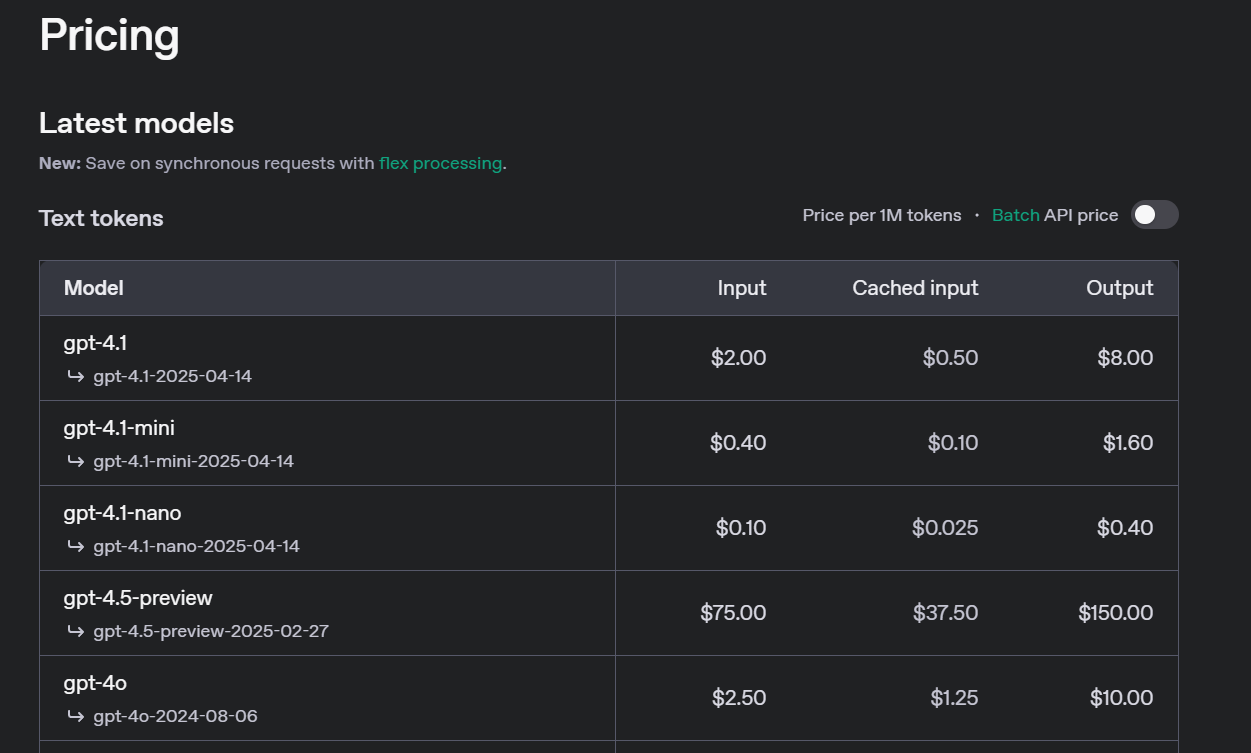

so now, the costs are:

On June 17, the prices for gpt4o are:

* Input: $0.0025 / 1K tokens
* Output: $0.01 / 1K tokens

In [ ]:
input_cost = 2.5 / 1000
output_cost = 10 / 1000

In [53]:
# For a single query the cost would be
unit_cost = (150 * input_cost) + (250 * output_cost)
unit_cost

2.875

In [55]:
total_cost = unit_cost * 1000
total_cost

2875.0

In [56]:
len(tokenized_prompt)

320

In [59]:
type(response)

openai.types.chat.chat_completion.ChatCompletion

In [66]:
print(response.usage)

CompletionUsage(completion_tokens=123, prompt_tokens=327, total_tokens=450, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))


In [62]:
response.dict()

/tmp/ipykernel_10633/3202056457.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response.dict()


{'id': 'chatcmpl-Bi3SKFvdMlk2tZ1Ja1CTLecVJPkA0',
 'choices': [{'finish_reason': 'stop',
   'index': 0,
   'logprobs': None,
   'message': {'content': 'To copy a file to a Docker container, you can use the `docker cp` command. The basic syntax is as follows:\n\n```bash\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\n```\n\nThis command allows you to copy files or directories from your local machine into a running Docker container. Make sure to replace `/path/to/local/file_or_directory` with the path of the file or directory on your local machine, `container_id` with the ID of the container you wish to copy the files to, and `/path/in/container` with the destination path inside the container.',
    'refusal': None,
    'role': 'assistant',
    'annotations': [],
    'audio': None,
    'function_call': None,
    'tool_calls': None}}],
 'created': 1749839416,
 'model': 'gpt-4o-2024-08-06',
 'object': 'chat.completion',
 'service_tier': 'default',
 'system_finge

In [63]:
response.dict()['usage']['completion_tokens']

/tmp/ipykernel_10633/2481144552.py:1: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response.dict()['usage']['completion_tokens']


123

In [64]:
import json
print(json.dumps(response.model_dump(), indent=2))


{
  "id": "chatcmpl-Bi3SKFvdMlk2tZ1Ja1CTLecVJPkA0",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "logprobs": null,
      "message": {
        "content": "To copy a file to a Docker container, you can use the `docker cp` command. The basic syntax is as follows:\n\n```bash\ndocker cp /path/to/local/file_or_directory container_id:/path/in/container\n```\n\nThis command allows you to copy files or directories from your local machine into a running Docker container. Make sure to replace `/path/to/local/file_or_directory` with the path of the file or directory on your local machine, `container_id` with the ID of the container you wish to copy the files to, and `/path/in/container` with the destination path inside the container.",
        "refusal": null,
        "role": "assistant",
        "annotations": [],
        "audio": null,
        "function_call": null,
        "tool_calls": null
      }
    }
  ],
  "created": 1749839416,
  "model": "gpt-4o-2024-08-06

In [67]:
prompt

'You\'re a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.\nUse only the facts from the CONTEXT when answering the QUESTION.\n\nQUESTION: How do copy a file to a Docker container?\n\nCONTEXT:\nQ: How do I debug a docker container?\nA: Launch the container image in interactive mode and overriding the entrypoint, so that it starts a bash command.\ndocker run -it --entrypoint bash <image>\nIf the container is already running, execute a command in the specific container:\ndocker ps (find the container-id)\ndocker exec -it <container-id> bash\n(Marcos MJD)\n\nQ: How do I copy files from my local machine to docker container?\nA: You can copy files from your local machine into a Docker container using the docker cp command. Here\'s how to do it:\nTo copy a file or directory from your local machine into a running Docker container, you can use the `docker cp command`. The basic syntax is as follows:\ndocker cp /path/to/local/file_or_directory container

In [68]:
tokenized_prompt

[63842,
 261,
 4165,
 14029,
 29186,
 13,
 30985,
 290,
 150339,
 4122,
 402,
 290,
 31810,
 8099,
 591,
 290,
 40251,
 7862,
 558,
 8470,
 1606,
 290,
 19719,
 591,
 290,
 31810,
 8099,
 1261,
 55959,
 290,
 150339,
 364,
 107036,
 25,
 3253,
 621,
 5150,
 261,
 1974,
 316,
 261,
 91238,
 9282,
 1715,
 10637,
 50738,
 734,
 48,
 25,
 3253,
 621,
 357,
 15199,
 261,
 62275,
 9282,
 3901,
 32,
 25,
 41281,
 290,
 9282,
 3621,
 306,
 25383,
 6766,
 326,
 151187,
 290,
 7251,
 4859,
 11,
 813,
 484,
 480,
 13217,
 261,
 38615,
 6348,
 558,
 68923,
 2461,
 533,
 278,
 2230,
 7962,
 4859,
 38615,
 464,
 3365,
 523,
 3335,
 290,
 9282,
 382,
 4279,
 6788,
 11,
 15792,
 261,
 6348,
 306,
 290,
 4857,
 9282,
 734,
 68923,
 10942,
 350,
 6555,
 290,
 9282,
 26240,
 446,
 68923,
 25398,
 533,
 278,
 464,
 6896,
 26240,
 29,
 38615,
 198,
 6103,
 277,
 10732,
 391,
 79771,
 1029,
 48,
 25,
 3253,
 621,
 357,
 5150,
 6291,
 591,
 922,
 2698,
 7342,
 316,
 62275,
 9282,
 3901,
 32,
 25,
 1608,
 665

In [69]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModel.from_pretrained("gpt2")

tokens = tokenizer("Hola mundo", return_tensors="pt")
outputs = model(**tokens, output_hidden_states=True)

# Obtienes los embeddings contextualizados (última capa)
last_hidden = outputs.last_hidden_state

print("Forma del vector para cada token:", last_hidden.shape)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Forma del vector para cada token: torch.Size([1, 4, 768])
